In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")

from models.vision_transformer import VisionTransformer
from layerwise_decay import param_groups_lrd, get_layer_id_for_vit, adjust_learning_rate

In [3]:
vit_lite = VisionTransformer(num_encoder_layers=2)

In [4]:
vit_lite

VisionTransformer(
  (patch_embedding): PatchEmbed(
    (project_patch): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (embed_dropout): Dropout(p=0.0, inplace=False)
  (encoder): VisionTransformerEncoder(
    (layers): ModuleList(
      (0): VisionTransformerEncoderLayer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attn): MultiheadAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (projection_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): MLP(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (activation): GELU()
          (dropout1): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=3072, out_feat

In [5]:
param_groups = param_groups_lrd(
    vit_lite, 
    no_weight_decay_list={'pos_embed', 'cls_token', 'dist_token'}, 
    verbose=True
)

parameter groups: 
{
  "layer_0_no_decay": {
    "lr_scale": 0.421875,
    "weight_decay": 0.0,
    "params": [
      "cls_token",
      "pos_embed",
      "patch_embedding.project_patch.bias"
    ]
  },
  "layer_0_decay": {
    "lr_scale": 0.421875,
    "weight_decay": 0.05,
    "params": [
      "patch_embedding.project_patch.weight"
    ]
  },
  "layer_1_no_decay": {
    "lr_scale": 0.5625,
    "weight_decay": 0.0,
    "params": [
      "encoder.layers.0.norm1.weight",
      "encoder.layers.0.norm1.bias",
      "encoder.layers.0.norm2.weight",
      "encoder.layers.0.norm2.bias",
      "encoder.layers.0.self_attn.qkv.bias",
      "encoder.layers.0.self_attn.proj.bias",
      "encoder.layers.0.mlp.linear1.bias",
      "encoder.layers.0.mlp.linear2.bias"
    ]
  },
  "layer_1_decay": {
    "lr_scale": 0.5625,
    "weight_decay": 0.05,
    "params": [
      "encoder.layers.0.self_attn.qkv.weight",
      "encoder.layers.0.self_attn.proj.weight",
      "encoder.layers.0.mlp.linear1.weigh

In [6]:
default_optim = torch.optim.AdamW(params=vit_lite.parameters(), lr=1)

In [7]:
default_optim

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1
    weight_decay: 0.01
)

(0.0, 50.0)

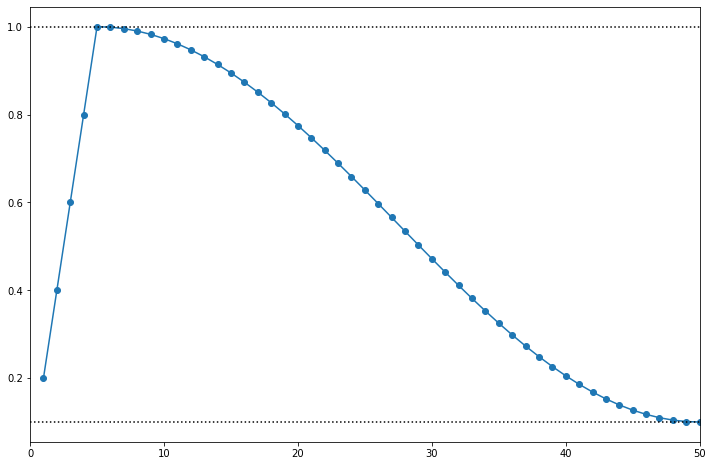

In [8]:
lr_list = []

for i in range(50):
    adjust_learning_rate(default_optim, epoch=i+1, lr_config={"lr": 1, "min_lr": 0.1})
    lr_list.append(default_optim.param_groups[0]["lr"])

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(range(1, 51), lr_list, "-o")

ax.plot([0, 50], [0.1, 0.1], "k:")
ax.plot([0, 50], [1, 1], "k:")
ax.set_xlim([0, 50])

In [9]:
optim = torch.optim.AdamW(param_groups, lr=1)

for gid, pg in enumerate(optim.param_groups):
    print("ParamGroup {}: lr={}, lr_scale={}, weight_decay={}".format(
        gid, 
        pg["lr"],
        pg["lr_scale"],
        pg["weight_decay"]
    ))

ParamGroup 0: lr=1, lr_scale=0.421875, weight_decay=0.0
ParamGroup 1: lr=1, lr_scale=0.421875, weight_decay=0.05
ParamGroup 2: lr=1, lr_scale=0.5625, weight_decay=0.0
ParamGroup 3: lr=1, lr_scale=0.5625, weight_decay=0.05
ParamGroup 4: lr=1, lr_scale=0.75, weight_decay=0.0
ParamGroup 5: lr=1, lr_scale=0.75, weight_decay=0.05
ParamGroup 6: lr=1, lr_scale=1.0, weight_decay=0.0
ParamGroup 7: lr=1, lr_scale=1.0, weight_decay=0.05


In [10]:
lr_groups = dict([("param_group_{}".format(i), []) for i in range(len(param_groups))])

for i in range(50):
    adjust_learning_rate(optimizer=optim, epoch=i+1, lr_config={"lr": 1, "min_lr": 0.1})

    for gid, pg in enumerate(optim.param_groups):
        lr_groups["param_group_{}".format(gid)].append(pg["lr"])

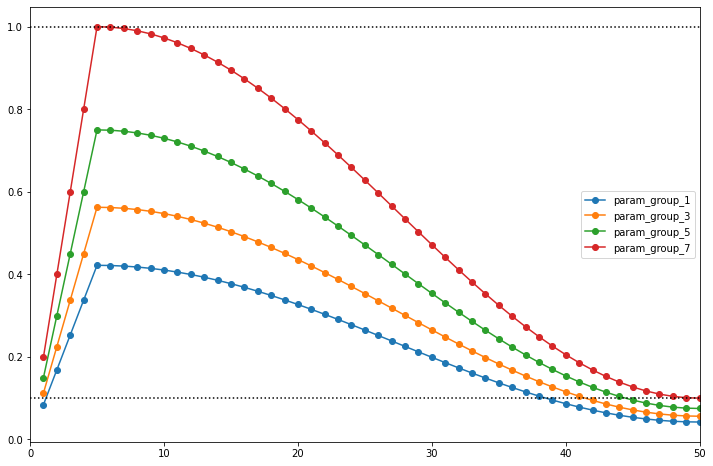

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

for k, v in lr_groups.items():
    if int(k.split("_")[-1]) % 2 == 0:
        continue

    ax.plot(range(1, 51), v, "-o", label=k)

ax.plot([0, 50], [0.1, 0.1], "k:")
ax.plot([0, 50], [1, 1], "k:")
ax.set_xlim([0, 50])
ax.legend()